In [1]:
import os
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
import easyocr
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = [{'name':'licence', 'id':1}]
labelmap_dir = r'.\Tensorflow\workspace\annotations\label_map.pbtxt'

with open(labelmap_dir, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [3]:
config_dir = r'.\Tensorflow\workspace\models\plate_recognition_model\pipeline.config'
config = config_util.get_configs_from_pipeline_file(config_dir)

In [4]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(config_dir, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [5]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = r'.\Tensorflow\workspace\pre-trained-models\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\checkpoint\cpkt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= r'.\Tensorflow\workspace\annotations\label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [r'.\Tensorflow\workspace\annotations.\train.record']
pipeline_config.eval_input_reader[0].label_map_path = r'.\Tensorflow\workspace\annotations\label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [r'.\Tensorflow\workspace\annotations.\test.record']

In [6]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(config_dir, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [ ]:
!python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\plate_recognition_model --pipeline_config_path=Tensorflow\workspace\models\plate_recognition_model\pipeline.config --num_train_steps=10000

In [21]:
configs = config_util.get_configs_from_pipeline_file(config_dir)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(r'.\Tensorflow\workspace\models\plate_recognition_model.\ckpt-6').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(r'.\Tensorflow\workspace\annotations\label_map.pbtxt')

In [23]:
image_dir = r'.\Tensorflow\workspace\images\test\Cars373.png'

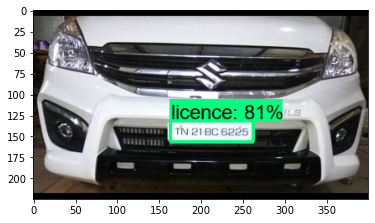

In [24]:
img = cv2.imread(image_dir)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.65,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
height = image_np_with_detections.shape[0]
width = image_np_with_detections.shape[1]

In [27]:
licence_coords = detections['detection_boxes'][0] * [height, width, height, width]

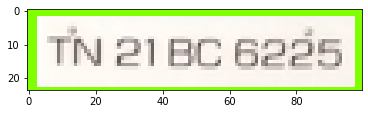

In [29]:
licence_region = image_np_with_detections[int(licence_coords[0]):int(licence_coords[2]),int(licence_coords[1]):int(licence_coords[3])]
plt.imshow(licence_region)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected plate numbers: TN 218C, 6225


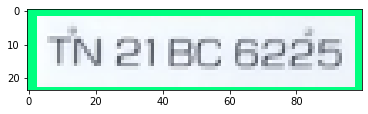

In [36]:
reader = easyocr.Reader(['en'])
ocr_result = reader.readtext(licence_region)
plt.imshow(cv2.cvtColor(licence_region, cv2.COLOR_BGR2RGB))
print("Detected plate numbers: " + ocr_result[0][1])